In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

In [1]:
using DifferentialEquations, Plots
pyplot()

@inline V(q1, q2) = 1//2 * (q1^2 + q2^2 + 2q1^2 * q2 - 2//3 * q2^3)
@inline T(p1, p2) = 1//2 * (p1^2 + p2^2)
@inline H(q1, q2, p1, p2) = T(p1, p2) + V(q1, q2)

function HamiltonEqs_q(t, q, p, dq)
    dq[1] = p[1]
    dq[2] = p[2]
end

function HamiltonEqs_p(t, q, p, dp)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

henon = @ode_def_noinvjac HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

q0 = [0.1, 0.]
p0 = [0., 0.5]
u0 = hcat(q0, p0)
E = H(u0[1],u0[2],u0[3],u0[4])

function g(u, resid)
    resid[1] = H(u[1],u[2],u[3],u[4]) - E
    resid[2:4] .= 0
end

cb = ManifoldProjection(g);

For the comparison we will use the following function

In [2]:
function compare(; tmax=1e2, maxiters=1e10)
    prob1 = ODEProblem(henon, u0, (0., tmax))
    prob2 = DynamicalODEProblem{true}(HamiltonEqs_q, HamiltonEqs_p, q0, p0, (0., tmax))
    @time sol1 = solve(prob1, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    @time sol2 = solve(prob2, KahanLi8(), dt=1e-2, maxiters=maxiters);
    @time sol3 = solve(prob2, Vern9(), abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    @time sol4 = solve(prob2, DPRKN12(), abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    
    println("Vern9 + ManifoldProjection max energy error: ", maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol1.u) .- E)))
    println("KahanLi8 max energy error: ",                   maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol2.u) .- E)))
    println("Vern9 max energy error: ",                      maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol3.u) .- E)))
    println("DPRKN12 max energy error: ",                    maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol4.u) .- E)))
    
    plot(xlabel="t", ylabel="Energy error")
    plot!(sol1.t, map(u->H(u[1],u[2],u[3],u[4]), sol1.u) .- E, label="Vern9 + ManifoldProjection")
    plot!(sol2.t, map(u->H(u[1],u[2],u[3],u[4]), sol2.u) .- E, label="KahanLi8")
    plot!(sol3.t, map(u->H(u[1],u[2],u[3],u[4]), sol3.u) .- E, label="Vern9")
    plot!(sol4.t, map(u->H(u[1],u[2],u[3],u[4]), sol4.u) .- E, label="DPRKN12")
end

compare (generic function with 1 method)

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error. 

  0.011581 seconds (123.68 k allocations: 12.155 MiB)
  0.066197 seconds (250.54 k allocations: 19.345 MiB, 14.68% gc time)
  0.065407 seconds (1.48 M allocations: 28.139 MiB, 20.32% gc time)
  0.017905 seconds (16.89 k allocations: 962.156 KiB, 81.58% gc time)
Vern9 + ManifoldProjection max energy error: 6.661338147750939e-16
KahanLi8 max energy error: 2.7478019859472624e-15
Vern9 max energy error: 6.661338147750939e-16
DPRKN12 max energy error: 2.4424906541753444e-15



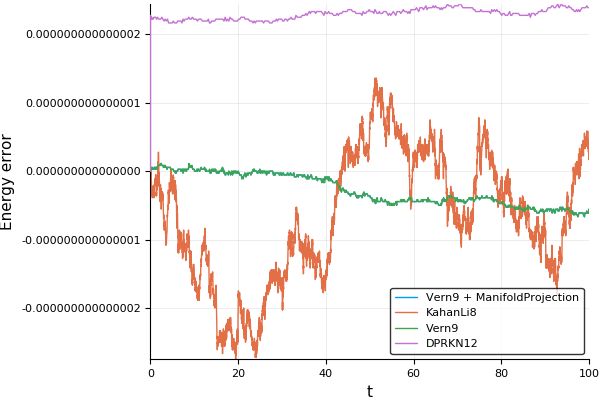

In [4]:
compare(tmax=1e2)

Because the energy error for the `Vern9` method is lower than the tolerance for `NLsolve`, this method and the `ManifoldProjection` version produce identical results.

  0.308547 seconds (1.22 M allocations: 120.618 MiB, 62.84% gc time)
  0.881687 seconds (2.50 M allocations: 191.142 MiB, 34.35% gc time)
  1.064842 seconds (14.68 M allocations: 279.201 MiB, 50.64% gc time)
  0.039533 seconds (146.22 k allocations: 8.221 MiB, 31.93% gc time)
Vern9 + ManifoldProjection max energy error: 4.496403249731884e-15
KahanLi8 max energy error: 1.2712053631958042e-14
Vern9 max energy error: 4.496403249731884e-15
DPRKN12 max energy error: 3.3029134982598407e-15



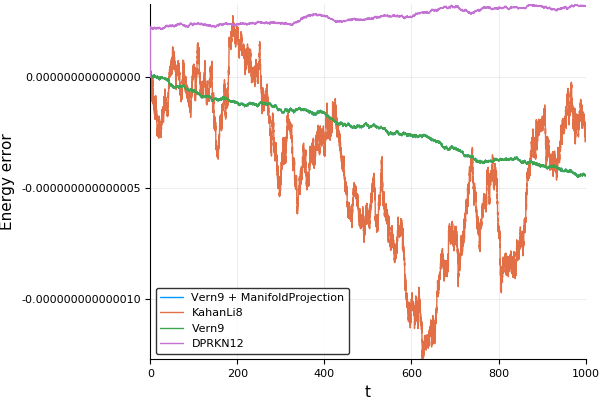

In [6]:
compare(tmax=1e3)

  2.840423 seconds (12.21 M allocations: 1.175 GiB, 57.90% gc time)
  7.466667 seconds (25.00 M allocations: 1.823 GiB, 20.60% gc time)
  8.875902 seconds (146.63 M allocations: 2.722 GiB, 40.07% gc time)
  0.428197 seconds (1.44 M allocations: 82.583 MiB, 34.68% gc time)
Vern9 + ManifoldProjection max energy error: 3.960720640350246e-14
KahanLi8 max energy error: 5.5261351050717167e-14
Vern9 max energy error: 3.960720640350246e-14
DPRKN12 max energy error: 9.631184738623233e-15



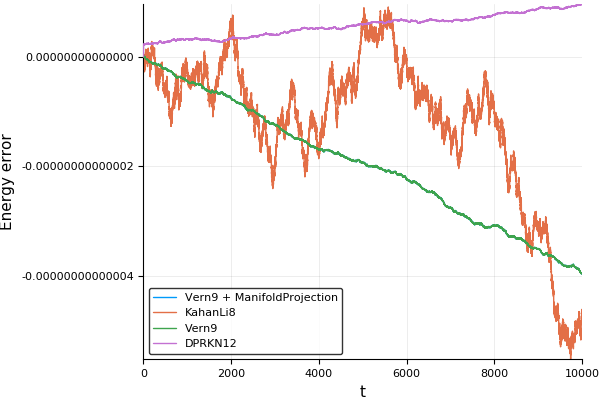

In [8]:
compare(tmax=1e4)

 17.220189 seconds (61.05 M allocations: 5.847 GiB, 65.61% gc time)
 41.677515 seconds (125.00 M allocations: 9.195 GiB, 27.76% gc time)
195.310595 seconds (733.09 M allocations: 13.584 GiB, 85.42% gc time)
 12.750677 seconds (7.19 M allocations: 404.410 MiB, 89.83% gc time)
Vern9 + ManifoldProjection max energy error: 9.997558336749535e-14
KahanLi8 max energy error: 9.181544413650045e-14
Vern9 max energy error: 2.0836110614652625e-13
DPRKN12 max energy error: 4.543587728278453e-14



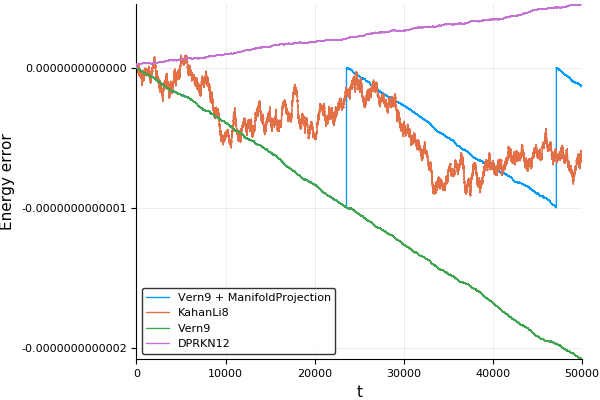

In [10]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable, but for smaller simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are relatively larger.
The above plot shows how the `Vern9` method and the `ManifoldProjection` version start to differ exactly when the energy error reaches the chosen tolerance for `NLsolve` (`ftol=1e-13`).